In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/25-1 보훈공공데이터 공모전/250625 final.csv')

#### PreProcessing

In [ ]:
df = df.drop(columns=['month_sin', 'month_cos'], errors='ignore')
df['연도'] = df['연도'].astype(int)
df['월'] = df['월'].astype(int)

In [ ]:
# 수학여생 시즌, 국가기념월 등 주요 시즌에 대한 가중치 부여
df['수학여행_시즌'] = df['월'].apply(lambda x: 1 if x in [4, 5, 10] else 0)
df['국가기념월'] = df['월'].apply(lambda x: 1 if x in [6, 8] else 0)

### Model

#### 1) Pycaret

In [ ]:
pip install pycaret

In [ ]:
from pycaret.regression import *

exp = setup(
    data=df,
    ignore_features=['단체관람객수'],
    target='관람객수',
    session_id=42,
    train_size=0.8,
)

best_model = compare_models()
predict_model(best_model)

,Description,Value
0,Session id,42
1,Target,관람객수
2,Target type,Regression
3,Original data shape,"(449, 17)"
4,Transformed data shape,"(449, 16)"
5,Transformed train set shape,"(359, 16)"
6,Transformed test set shape,"(90, 16)"
7,Ignore features,1
8,Numeric features,15
9,Rows with missing values,9.1%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,39719.5904,4411090896.0009,63568.0306,0.7447,0.6163,0.3159,0.0300
lightgbm,Light Gradient Boosting Machine,45467.7984,5715132133.9396,71657.9429,0.7171,0.6538,0.3429,45.9250
et,Extra Trees Regressor,38628.7008,5675204074.3699,70863.7196,0.7121,0.5873,0.2741,0.0350
rf,Random Forest Regressor,42995.2823,5794034115.4425,73074.0993,0.6674,0.6240,0.3169,0.0540
xgboost,Extreme Gradient Boosting,43579.0090,6394097484.8000,77463.0723,0.6221,0.6231,0.2906,0.0730
ada,AdaBoost Regressor,78715.8527,10575964014.7836,101303.1245,0.3863,0.9612,0.9741,0.0220
dt,Decision Tree Regressor,62049.3539,11177710359.7658,103296.4147,0.3450,0.8958,0.4011,0.0110
knn,K Neighbors Regressor,69353.2309,13402952960.0000,111142.2719,0.3121,0.7930,0.5022,0.0120
en,Elastic Net,76062.5171,13975957018.4129,113764.6113,0.2736,0.8962,0.7103,0.0120
lasso,Lasso Regression,76690.1941,14039496583.6815,114099.7941,0.2676,0.9113,0.7171,0.3060


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,51773.1929,10563450521.7954,102778.6482,0.6521,0.3183,0.2753


,연도,월,전시,문화,학술,교육,기타,공휴일수,평균기온(°C),평균최고기온(°C),평균최저기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),일최다강수량(mm),관람객수,prediction_label
285,2011,10,0,0,0,0,0,1,12.700000,19.900000,6.7,24.900000,-0.9,26.500000,9.000000,209271.0,182321.195775
296,2012,9,0,0,0,0,0,2,20.000000,25.400000,15.7,30.299999,9.9,190.100006,97.500000,120936.0,116139.506571
117,1997,10,0,0,0,0,0,1,12.600000,20.200001,5.4,27.200001,-2.5,23.000000,8.000000,171791.0,148917.575470
347,2016,12,0,0,0,0,0,1,1.100000,6.700000,-4.2,14.000000,-12.0,44.299999,21.299999,75821.0,110461.813310
70,1993,11,0,0,0,0,0,0,7.700000,12.700000,3.3,19.400000,-9.1,66.900002,23.500000,89320.0,149521.041858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,2024,9,0,80,0,0,0,3,24.400000,29.500000,20.5,34.099998,13.1,318.000000,152.500000,247297.0,394865.064291
368,2018,9,105,102,4,12,0,4,19.299999,24.799999,14.2,28.799999,7.4,124.599998,72.199997,463237.0,298161.328309
57,1992,10,0,0,0,0,0,1,12.800000,19.700001,7.3,24.700001,0.5,18.000000,5.000000,179642.0,196457.406893
430,2023,11,43,11,0,0,0,0,6.700000,12.500000,1.3,25.799999,-7.4,56.900002,21.000000,493355.0,465751.370321


#### 2) LSTM

In [ ]:
df.columns

Index(['연도', '월', '관람객수', '전시', '문화', '학술', '교육', '기타', '공휴일수', '평균기온(°C)',
       '평균최고기온(°C)', '평균최저기온(°C)', '최고기온(°C)', '최저기온(°C)',
       '월합강수량(00~24h만)(mm)', '일최다강수량(mm)', '단체관람객수'],
      dtype='object')

In [ ]:
pip install scikit-learn pandas numpy matplotlib tensorflow

In [ ]:
# LSTM용 코드 전처리
features = [
    '전시', '문화', '학술', '교육', '기타', '공휴일수',
    '평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)',
    '최고기온(°C)', '최저기온(°C)',
    '월합강수량(00~24h만)(mm)', '일최다강수량(mm)'
]
target = '관람객수'

df_lstm = df.sort_values(by=['연도', '월']).reset_index(drop=True)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_lstm[features + [target]])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])
        y.append(data[i+window_size, -1])
    return np.array(X), np.array(y)


window_size = 6
X, y = create_sequences(df_scaled, window_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1. 훈련/테스트 데이터 분리
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 2. 모델 구성
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 3. 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0057 - val_loss: 0.0609
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0776
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0660
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0655
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0646
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0608
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0703
Epoch 8/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0595
Epoch 9/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 0.0654
Epoch 10/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0704
Epoch 11/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0627
Epoch 12/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

X_last = X_test[:, -1, :]
y_test_full = np.concatenate([X_last, y_test.reshape(-1, 1)], axis=1)
y_pred_full = np.concatenate([X_last, y_pred], axis=1)

y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]


print(f"역변환 후 RMSE: {mean_squared_error(y_test_inv, y_pred_inv, squared=False):.2f}")
print(f"역변환 후 MAE: {mean_absolute_error(y_test_inv, y_pred_inv):.2f}")
print(f"역변환 후 R²: {r2_score(y_test_inv, y_pred_inv):.4f}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
역변환 후 RMSE: 277923.48
역변환 후 MAE: 213326.97
역변환 후 R²: -0.8918


#### 3) Transformer

In [ ]:
df.columns

Index(['연도', '월', '관람객수', '전시', '문화', '학술', '교육', '기타', '공휴일수', '평균기온(°C)',
       '평균최고기온(°C)', '평균최저기온(°C)', '최고기온(°C)', '최저기온(°C)',
       '월합강수량(00~24h만)(mm)', '일최다강수량(mm)', '단체관람객수'],
      dtype='object')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.6432
Epoch 2, Loss: 0.0248
Epoch 3, Loss: 0.0162
Epoch 4, Loss: 0.0152
Epoch 5, Loss: 0.0148
Epoch 6, Loss: 0.0152
Epoch 7, Loss: 0.0124
Epoch 8, Loss: 0.0124
Epoch 9, Loss: 0.0112
Epoch 10, Loss: 0.0103
Epoch 11, Loss: 0.0103
Epoch 12, Loss: 0.0103
Epoch 13, Loss: 0.0093
Epoch 14, Loss: 0.0088
Epoch 15, Loss: 0.0085
Epoch 16, Loss: 0.0079
Epoch 17, Loss: 0.0084
Epoch 18, Loss: 0.0087
Epoch 19, Loss: 0.0095
Epoch 20, Loss: 0.0076
Epoch 21, Loss: 0.0070
Epoch 22, Loss: 0.0071
Epoch 23, Loss: 0.0084
Epoch 24, Loss: 0.0068
Epoch 25, Loss: 0.0064
Epoch 26, Loss: 0.0069
Epoch 27, Loss: 0.0057
Epoch 28, Loss: 0.0060
Epoch 29, Loss: 0.0065
Epoch 30, Loss: 0.0054
Epoch 31, Loss: 0.0066
Epoch 32, Loss: 0.0055
Epoch 33, Loss: 0.0064
Epoch 34, Loss: 0.0075
Epoch 35, Loss: 0.0052
Epoch 36, Loss: 0.0045
Epoch 37, Loss: 0.0048
Epoch 38, Loss: 0.0048
Epoch 39, Loss: 0.0041
Epoch 40, Loss: 0.0044
Epoch 41, Loss: 0.0042
Epoch 42, Loss: 0.0062
Epoch 43, Loss: 0.0044
Epoch 44, Loss: 0.00

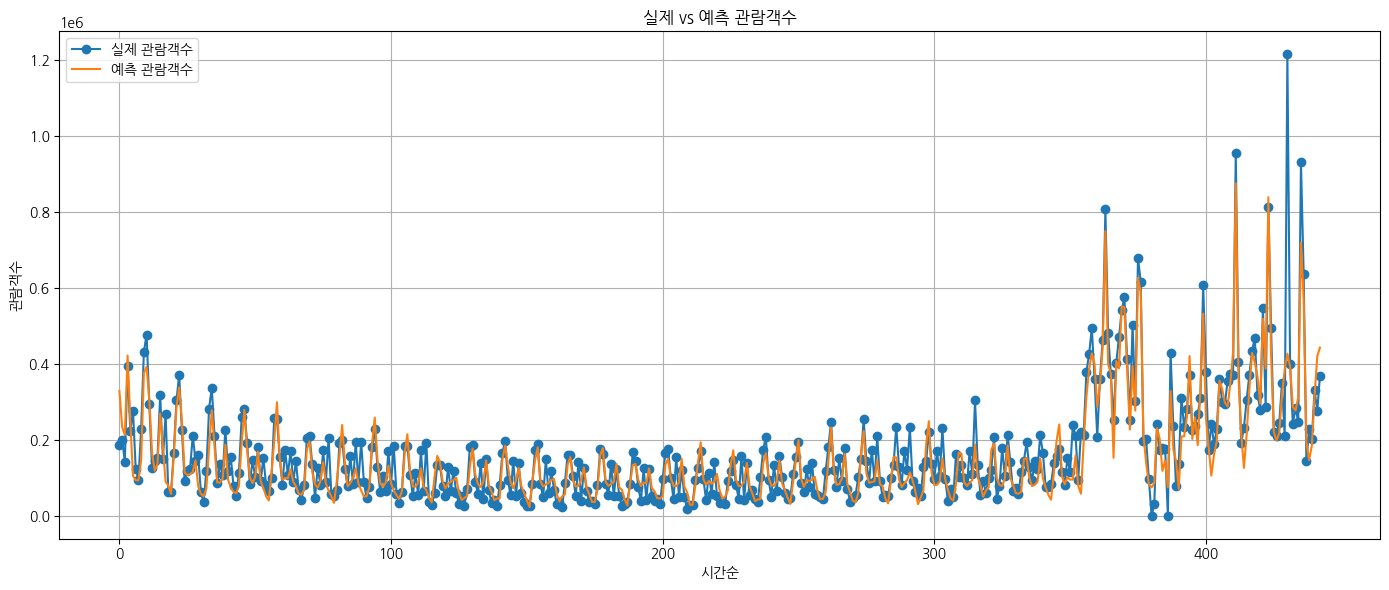

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math

# 데이터 전처리
features = [
    '전시', '문화', '학술', '교육', '기타', '공휴일수',
    '평균기온(°C)', '월합강수량(00~24h만)(mm)',
    '관람객수'
]
df_seq = df[features].dropna().reset_index(drop=True).copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_seq)

window_size = 6
X, y = [], []
for i in range(len(scaled) - window_size):
    X.append(scaled[i:i+window_size])
    y.append(scaled[i+window_size][-1])
X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 데이터로더
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 모델 정의
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, nhead=4, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0, 2)
        out = self.transformer_encoder(src)
        out = out[-1, :, :]
        return self.fc_out(out).squeeze()

model = TimeSeriesTransformer(X.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# 예측
model.eval()
with torch.no_grad():
    preds_scaled = model(X_tensor).numpy()

# 역변환
관람객수_idx = df_seq.columns.get_loc('관람객수')
관람객수_min = scaler.data_min_[관람객수_idx]
관람객수_max = scaler.data_max_[관람객수_idx]

y_actual = y * (관람객수_max - 관람객수_min) + 관람객수_min
preds_actual = preds_scaled * (관람객수_max - 관람객수_min) + 관람객수_min

# 평가
rmse = math.sqrt(mean_squared_error(y_actual, preds_actual))
mae = mean_absolute_error(y_actual, preds_actual)
r2 = r2_score(y_actual, preds_actual)

print(f"역변환 후 RMSE: {rmse:,.2f}")
print(f"역변환 후 MAE: {mae:,.2f}")
print(f"역변환 후 R²: {r2:.4f}")

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_actual, label='실제 관람객수', marker='o')
plt.plot(preds_actual, label='예측 관람객수')
plt.legend()
plt.title("실제 vs 예측 관람객수")
plt.xlabel("시간순")
plt.ylabel("관람객수")
plt.grid(True)
plt.tight_layout()
plt.show()

Transformer Model 개선 버전

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/25-1 보훈공공데이터 공모전/관람객수_축제_병합데이터.csv')

### 1. Data Preprocessing

In [ ]:
df = df.drop(columns=['month_sin', 'month_cos'], errors='ignore')
df['연도'] = df['연도'].astype(int)
df['월'] = df['월'].astype(int)

In [ ]:
df_month_ohe = pd.get_dummies(df['월'], prefix='월')
df = pd.concat([df, df_month_ohe], axis=1)

In [ ]:
# EDA의 내용을 기반으로 수학여행시즌, 독립운동기념일에 가중치 부여
df['수학여행시즌'] = df['월'].apply(lambda x: 1 if x in [5, 10] else 0)
df['독립운동기념일'] = df['월'].apply(lambda x: 1 if x in [6, 8] else 0)

In [ ]:
# 과거 정보에 대한 힌트 제공
df['관람객수_lag1'] = df['관람객수'].shift(1)
df['관람객수_lag2'] = df['관람객수'].shift(2)
df['관람객수_ma3'] = df['관람객수'].rolling(window=3).mean()

In [ ]:
df_ht = df.drop(columns=['월'])

In [ ]:
df_v6 = df_ht.drop(columns = ['월_1', '월_2', '월_3', '월_4', '공휴일수', '월_5', '월_8', '월합강수량(00~24h만)(mm)',
'월_10', '월_7', '월_9'])

### 2. Model 준비

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math

In [ ]:
# 데이터 전처리
features = [
    '전시', '문화', '학술', '교육', '기타', '공휴일수',
    '평균기온(°C)', '월합강수량(00~24h만)(mm)',
    '총축제방문객수', '수학여행시즌', '독립운동기념일',
    '관람객수_lag1', '관람객수_lag2', '관람객수_ma3',
    '관람객수'
]

month_ohe_cols = [col for col in df_ht.columns if col.startswith('월_')]
features += month_ohe_cols

df_seq = df_ht[features].dropna().reset_index(drop=True).copy()

continuous_cols = [
    '전시', '문화', '학술', '교육', '기타', '공휴일수',
    '총축제방문객수', '평균기온(°C)', '월합강수량(00~24h만)(mm)',
    '수학여행시즌', '독립운동기념일',
    '관람객수_lag1', '관람객수_lag2', '관람객수_ma3',
    '관람객수'
]

scaler = MinMaxScaler()
scaled_continuous = scaler.fit_transform(df_seq[continuous_cols])
df_scaled = pd.DataFrame(scaled_continuous, columns=continuous_cols)
df_ohe = df_seq.drop(columns=continuous_cols).reset_index(drop=True)
df_ohe = df_ohe.astype(float)
df_scaled_all = pd.concat([df_scaled, df_ohe], axis=1)

scaled = df_scaled_all.values

관람객수_min = scaler.data_min_[continuous_cols.index('관람객수')]
관람객수_max = scaler.data_max_[continuous_cols.index('관람객수')]


In [ ]:
window_size = 12
X, y = [], []
관람객수_idx = df_scaled_all.columns.get_loc('관람객수')

for i in range(len(scaled) - window_size):
    X.append(scaled[i:i+window_size])
    y.append(scaled[i+window_size][관람객수_idx])
X = np.array(X)
y = np.array(y)

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# 모델 정의
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=128, nhead=4, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0, 2)
        out = self.transformer_encoder(src)
        out = out[-1, :, :]
        return self.fc_out(out).squeeze()

model = TimeSeriesTransformer(X.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# 모델 정의 with Post Encoder + Label Smoothing
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, nhead=4, num_layers=2, dropout=0.1, max_len=500):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2)
        out = self.transformer_encoder(src)
        out = out[-1, :, :]
        return self.fc_out(out).squeeze()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


model = TimeSeriesTransformer(input_dim=X.shape[2])
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# HyBrid Model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out

input_dim = X_tensor.shape[2]  # feature 개수
model = LSTMWithAttention(input_dim=input_dim, hidden_dim=64, num_layers=2, output_dim=1)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 3. 모델 학습 및 예측

In [ ]:
# 학습 개선
best_loss = float('inf')
patience = 10
counter = 0

for epoch in range(200):
    model.train()
    total_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        #loss = criterion(preds.squeeze(), batch_y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Early Stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"🔥 Early stopping at epoch {epoch+1}")
            break

# 최적 모델 적용
model.load_state_dict(best_model_state)

Epoch 1, Loss: 0.0014
Epoch 2, Loss: 0.0015
Epoch 3, Loss: 0.0014
Epoch 4, Loss: 0.0012
Epoch 5, Loss: 0.0018
Epoch 6, Loss: 0.0018
Epoch 7, Loss: 0.0018
Epoch 8, Loss: 0.0019
Epoch 9, Loss: 0.0013
Epoch 10, Loss: 0.0013
Epoch 11, Loss: 0.0013
Epoch 12, Loss: 0.0011
Epoch 13, Loss: 0.0011
Epoch 14, Loss: 0.0014
Epoch 15, Loss: 0.0017
Epoch 16, Loss: 0.0012
Epoch 17, Loss: 0.0011
Epoch 18, Loss: 0.0011
Epoch 19, Loss: 0.0013
Epoch 20, Loss: 0.0025
Epoch 21, Loss: 0.0017
Epoch 22, Loss: 0.0012
🔥 Early stopping at epoch 22


<All keys matched successfully>

In [ ]:
# 예측
model.eval()
with torch.no_grad():
    preds_scaled = model(X_tensor).numpy()

# 역변환
y_actual = y * (관람객수_max - 관람객수_min) + 관람객수_min
preds_actual = preds_scaled * (관람객수_max - 관람객수_min) + 관람객수_min

# 평가
rmse = math.sqrt(mean_squared_error(y_actual, preds_actual))
mae = mean_absolute_error(y_actual, preds_actual)
r2 = r2_score(y_actual, preds_actual)

print(f"역변환 후 RMSE: {rmse:,.2f}")
print(f"역변환 후 MAE: {mae:,.2f}")
print(f"역변환 후 R²: {r2:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [394, 400]

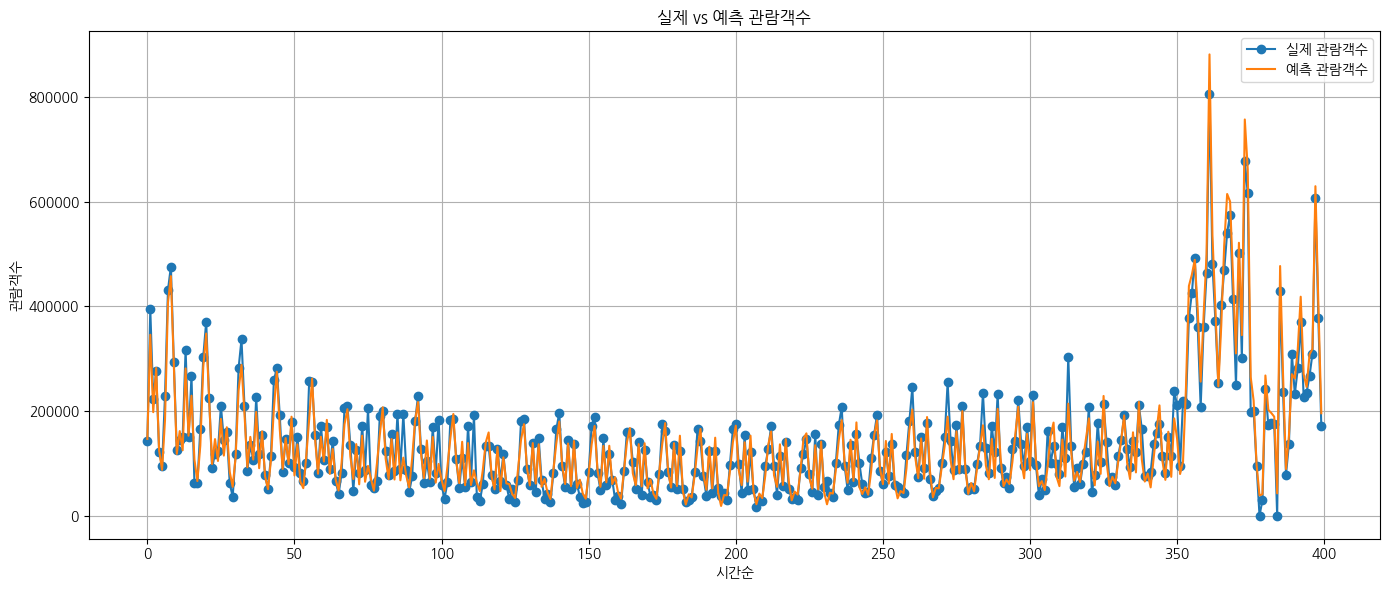

In [ ]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_actual, label='실제 관람객수', marker='o')
plt.plot(preds_actual, label='예측 관람객수')
plt.legend()
plt.title("실제 vs 예측 관람객수")
plt.xlabel("시간순")
plt.ylabel("관람객수")
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Permutation Importance

In [ ]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X_tensor, y_tensor, baseline_preds, feature_names, scaler, 관람객수_min, 관람객수_max):
    importances = []
    X_base = X_tensor.clone()

    for i, name in enumerate(feature_names):
        X_perm = X_base.clone()
        X_perm[:, :, i] = X_perm[torch.randperm(X_perm.size(0)), :, i]

        with torch.no_grad():
            preds_perm = model(X_perm).numpy()

        preds_actual_perm = preds_perm * (관람객수_max - 관람객수_min) + 관람객수_min
        baseline_actual = baseline_preds * (관람객수_max - 관람객수_min) + 관람객수_min
        y_actual = y_tensor.numpy() * (관람객수_max - 관람객수_min) + 관람객수_min

        mse_perm = mean_squared_error(y_actual, preds_actual_perm)
        mse_base = mean_squared_error(y_actual, baseline_actual)
        importances.append(mse_perm - mse_base)

    return list(zip(feature_names, importances))

In [ ]:
with torch.no_grad():
    baseline_preds = model(X_tensor).numpy()

# feature 순서
feature_names = df_scaled_all.columns.tolist()

# 중요도 계산
importances = permutation_importance(
    model, X_tensor, y_tensor, baseline_preds,
    feature_names, scaler,
    관람객수_min, 관람객수_max
)

# 정렬 및 출력
importances_sorted = sorted(importances, key=lambda x: x[1], reverse=True)
for name, score in importances_sorted:
    print(f"{name}: {score:.4f}")

관람객수_ma3: 2131994700.7443
관람객수: 1986915280.4411
총축제방문객수: 1480422858.0627
전시: 1377005028.1740
월_6: 1349088707.0296
월_11: 1052907683.7556
월_12: 1000220659.3590
월_3: 868493620.7308
월_1: 777334297.8393
월_9: 717408343.9336
관람객수_lag1: 426281801.1423
교육: 385475615.9402
월_4: 378626420.0896
관람객수_lag2: 376816685.7988
독립운동기념일: 356833402.3929
기타: 288353831.0409
수학여행시즌: 230856317.6992
평균기온(°C): 186200829.7394
문화: 168235830.2196
학술: 155004612.5660
월_10: 152017795.9786
월_7: 106770371.9056
월_2: 89130089.1672
공휴일수: 79060634.4033
월_5: 74393083.9787
월_8: 57900555.2567
월합강수량(00~24h만)(mm): 45337981.3088


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/25-1 보훈공공데이터 공모전/250625 final.csv')

#### PreProcessing

In [ ]:
df = df.drop(columns=['month_sin', 'month_cos'], errors='ignore')
df['연도'] = df['연도'].astype(int)
df['월'] = df['월'].astype(int)

In [ ]:
# 수학여생 시즌, 국가기념월 등 주요 시즌에 대한 가중치 부여
df['수학여행_시즌'] = df['월'].apply(lambda x: 1 if x in [4, 5, 10] else 0)
df['국가기념월'] = df['월'].apply(lambda x: 1 if x in [6, 8] else 0)

### Model

#### 1) Pycaret

In [ ]:
pip install pycaret

In [ ]:
from pycaret.regression import *

exp = setup(
    data=df,
    ignore_features=['단체관람객수'],
    target='관람객수',
    session_id=42,
    train_size=0.8,
)

best_model = compare_models()
predict_model(best_model)

,Description,Value
0,Session id,42
1,Target,관람객수
2,Target type,Regression
3,Original data shape,"(449, 17)"
4,Transformed data shape,"(449, 16)"
5,Transformed train set shape,"(359, 16)"
6,Transformed test set shape,"(90, 16)"
7,Ignore features,1
8,Numeric features,15
9,Rows with missing values,9.1%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,39719.5904,4411090896.0009,63568.0306,0.7447,0.6163,0.3159,0.0300
lightgbm,Light Gradient Boosting Machine,45467.7984,5715132133.9396,71657.9429,0.7171,0.6538,0.3429,45.9250
et,Extra Trees Regressor,38628.7008,5675204074.3699,70863.7196,0.7121,0.5873,0.2741,0.0350
rf,Random Forest Regressor,42995.2823,5794034115.4425,73074.0993,0.6674,0.6240,0.3169,0.0540
xgboost,Extreme Gradient Boosting,43579.0090,6394097484.8000,77463.0723,0.6221,0.6231,0.2906,0.0730
ada,AdaBoost Regressor,78715.8527,10575964014.7836,101303.1245,0.3863,0.9612,0.9741,0.0220
dt,Decision Tree Regressor,62049.3539,11177710359.7658,103296.4147,0.3450,0.8958,0.4011,0.0110
knn,K Neighbors Regressor,69353.2309,13402952960.0000,111142.2719,0.3121,0.7930,0.5022,0.0120
en,Elastic Net,76062.5171,13975957018.4129,113764.6113,0.2736,0.8962,0.7103,0.0120
lasso,Lasso Regression,76690.1941,14039496583.6815,114099.7941,0.2676,0.9113,0.7171,0.3060


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,51773.1929,10563450521.7954,102778.6482,0.6521,0.3183,0.2753


,연도,월,전시,문화,학술,교육,기타,공휴일수,평균기온(°C),평균최고기온(°C),평균최저기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),일최다강수량(mm),관람객수,prediction_label
285,2011,10,0,0,0,0,0,1,12.700000,19.900000,6.7,24.900000,-0.9,26.500000,9.000000,209271.0,182321.195775
296,2012,9,0,0,0,0,0,2,20.000000,25.400000,15.7,30.299999,9.9,190.100006,97.500000,120936.0,116139.506571
117,1997,10,0,0,0,0,0,1,12.600000,20.200001,5.4,27.200001,-2.5,23.000000,8.000000,171791.0,148917.575470
347,2016,12,0,0,0,0,0,1,1.100000,6.700000,-4.2,14.000000,-12.0,44.299999,21.299999,75821.0,110461.813310
70,1993,11,0,0,0,0,0,0,7.700000,12.700000,3.3,19.400000,-9.1,66.900002,23.500000,89320.0,149521.041858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,2024,9,0,80,0,0,0,3,24.400000,29.500000,20.5,34.099998,13.1,318.000000,152.500000,247297.0,394865.064291
368,2018,9,105,102,4,12,0,4,19.299999,24.799999,14.2,28.799999,7.4,124.599998,72.199997,463237.0,298161.328309
57,1992,10,0,0,0,0,0,1,12.800000,19.700001,7.3,24.700001,0.5,18.000000,5.000000,179642.0,196457.406893
430,2023,11,43,11,0,0,0,0,6.700000,12.500000,1.3,25.799999,-7.4,56.900002,21.000000,493355.0,465751.370321


#### 2) LSTM

In [ ]:
df.columns

Index(['연도', '월', '관람객수', '전시', '문화', '학술', '교육', '기타', '공휴일수', '평균기온(°C)',
       '평균최고기온(°C)', '평균최저기온(°C)', '최고기온(°C)', '최저기온(°C)',
       '월합강수량(00~24h만)(mm)', '일최다강수량(mm)', '단체관람객수'],
      dtype='object')

In [ ]:
pip install scikit-learn pandas numpy matplotlib tensorflow

In [ ]:
# LSTM용 코드 전처리
features = [
    '전시', '문화', '학술', '교육', '기타', '공휴일수',
    '평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)',
    '최고기온(°C)', '최저기온(°C)',
    '월합강수량(00~24h만)(mm)', '일최다강수량(mm)'
]
target = '관람객수'

df_lstm = df.sort_values(by=['연도', '월']).reset_index(drop=True)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_lstm[features + [target]])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])
        y.append(data[i+window_size, -1])
    return np.array(X), np.array(y)


window_size = 6
X, y = create_sequences(df_scaled, window_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1. 훈련/테스트 데이터 분리
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 2. 모델 구성
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 3. 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0057 - val_loss: 0.0609
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0776
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0660
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0655
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0646
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0608
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0703
Epoch 8/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0595
Epoch 9/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 0.0654
Epoch 10/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0704
Epoch 11/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0627
Epoch 12/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

X_last = X_test[:, -1, :]
y_test_full = np.concatenate([X_last, y_test.reshape(-1, 1)], axis=1)
y_pred_full = np.concatenate([X_last, y_pred], axis=1)

y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]


print(f"역변환 후 RMSE: {mean_squared_error(y_test_inv, y_pred_inv, squared=False):.2f}")
print(f"역변환 후 MAE: {mean_absolute_error(y_test_inv, y_pred_inv):.2f}")
print(f"역변환 후 R²: {r2_score(y_test_inv, y_pred_inv):.4f}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
역변환 후 RMSE: 277923.48
역변환 후 MAE: 213326.97
역변환 후 R²: -0.8918


#### 3) Transformer

In [ ]:
df.columns

Index(['연도', '월', '관람객수', '전시', '문화', '학술', '교육', '기타', '공휴일수', '평균기온(°C)',
       '평균최고기온(°C)', '평균최저기온(°C)', '최고기온(°C)', '최저기온(°C)',
       '월합강수량(00~24h만)(mm)', '일최다강수량(mm)', '단체관람객수'],
      dtype='object')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.6432
Epoch 2, Loss: 0.0248
Epoch 3, Loss: 0.0162
Epoch 4, Loss: 0.0152
Epoch 5, Loss: 0.0148
Epoch 6, Loss: 0.0152
Epoch 7, Loss: 0.0124
Epoch 8, Loss: 0.0124
Epoch 9, Loss: 0.0112
Epoch 10, Loss: 0.0103
Epoch 11, Loss: 0.0103
Epoch 12, Loss: 0.0103
Epoch 13, Loss: 0.0093
Epoch 14, Loss: 0.0088
Epoch 15, Loss: 0.0085
Epoch 16, Loss: 0.0079
Epoch 17, Loss: 0.0084
Epoch 18, Loss: 0.0087
Epoch 19, Loss: 0.0095
Epoch 20, Loss: 0.0076
Epoch 21, Loss: 0.0070
Epoch 22, Loss: 0.0071
Epoch 23, Loss: 0.0084
Epoch 24, Loss: 0.0068
Epoch 25, Loss: 0.0064
Epoch 26, Loss: 0.0069
Epoch 27, Loss: 0.0057
Epoch 28, Loss: 0.0060
Epoch 29, Loss: 0.0065
Epoch 30, Loss: 0.0054
Epoch 31, Loss: 0.0066
Epoch 32, Loss: 0.0055
Epoch 33, Loss: 0.0064
Epoch 34, Loss: 0.0075
Epoch 35, Loss: 0.0052
Epoch 36, Loss: 0.0045
Epoch 37, Loss: 0.0048
Epoch 38, Loss: 0.0048
Epoch 39, Loss: 0.0041
Epoch 40, Loss: 0.0044
Epoch 41, Loss: 0.0042
Epoch 42, Loss: 0.0062
Epoch 43, Loss: 0.0044
Epoch 44, Loss: 0.00

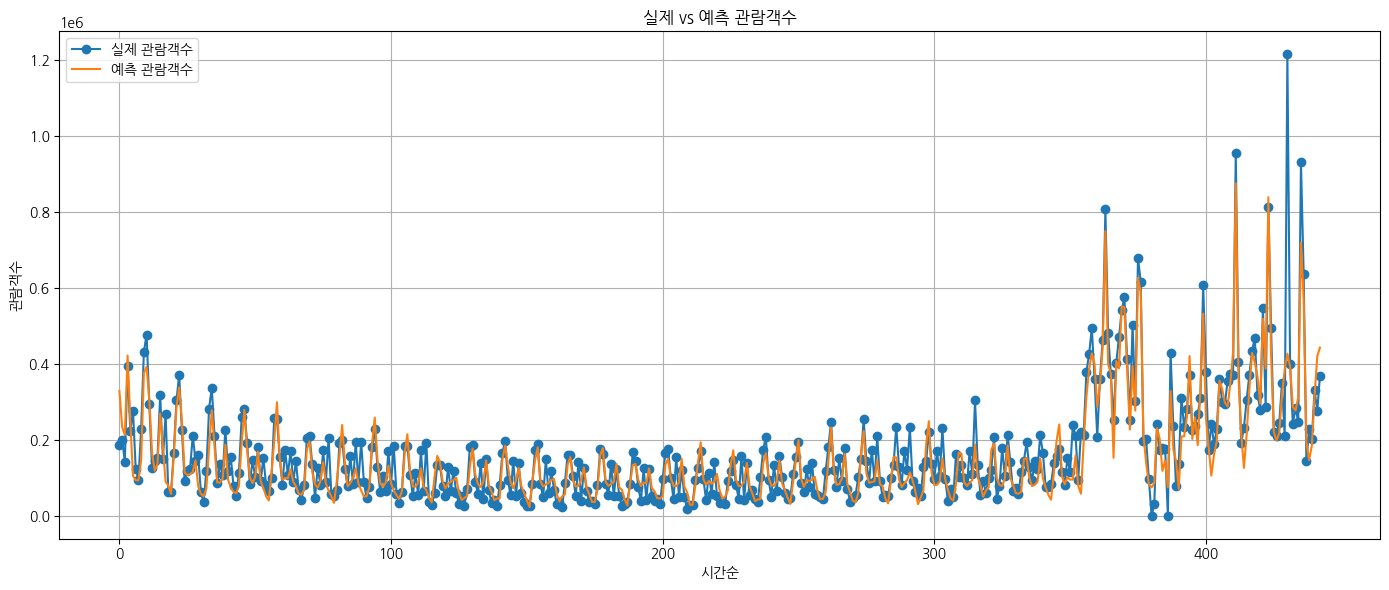

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math

# 데이터 전처리
features = [
    '전시', '문화', '학술', '교육', '기타', '공휴일수',
    '평균기온(°C)', '월합강수량(00~24h만)(mm)',
    '관람객수'
]
df_seq = df[features].dropna().reset_index(drop=True).copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_seq)

window_size = 6
X, y = [], []
for i in range(len(scaled) - window_size):
    X.append(scaled[i:i+window_size])
    y.append(scaled[i+window_size][-1])
X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 데이터로더
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 모델 정의
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, nhead=4, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0, 2)
        out = self.transformer_encoder(src)
        out = out[-1, :, :]
        return self.fc_out(out).squeeze()

model = TimeSeriesTransformer(X.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# 예측
model.eval()
with torch.no_grad():
    preds_scaled = model(X_tensor).numpy()

# 역변환
관람객수_idx = df_seq.columns.get_loc('관람객수')
관람객수_min = scaler.data_min_[관람객수_idx]
관람객수_max = scaler.data_max_[관람객수_idx]

y_actual = y * (관람객수_max - 관람객수_min) + 관람객수_min
preds_actual = preds_scaled * (관람객수_max - 관람객수_min) + 관람객수_min

# 평가
rmse = math.sqrt(mean_squared_error(y_actual, preds_actual))
mae = mean_absolute_error(y_actual, preds_actual)
r2 = r2_score(y_actual, preds_actual)

print(f"역변환 후 RMSE: {rmse:,.2f}")
print(f"역변환 후 MAE: {mae:,.2f}")
print(f"역변환 후 R²: {r2:.4f}")

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_actual, label='실제 관람객수', marker='o')
plt.plot(preds_actual, label='예측 관람객수')
plt.legend()
plt.title("실제 vs 예측 관람객수")
plt.xlabel("시간순")
plt.ylabel("관람객수")
plt.grid(True)
plt.tight_layout()
plt.show()